In [1]:
import os 

os.chdir("/home/hamza-arain/Documents/code/recmmendation")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv("data/online_retail_final.csv")
# df = pd.read_csv("data/data.csv", encoding="ISO-8859-1")

display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


(404090, 9)


<a id="section-five-one"></a>

# 5.1) Data Preparation for Time Series

In [4]:
df = df[df.Country == "United Kingdom"]

In [5]:
df.loc[:, "InvoiceDate"] = pd.to_datetime(df.loc[:, "InvoiceDate"])

print(f"First observation on data is {df.InvoiceDate.min()}")
print(f"Last observation on data is {df.InvoiceDate.max()}")

print(f"We have {(df.InvoiceDate.max() - df.InvoiceDate.min()).days} days.")

First observation on data is 2010-12-01 08:26:00
Last observation on data is 2011-12-09 12:49:00
We have 373 days.


In [6]:
df.set_index("InvoiceDate", inplace = True)
df.head(2)

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34


<a id="section-five-one-one"></a>

# 5.1.1) Weekly

In [7]:
prices_df = pd.DataFrame(df.groupby("InvoiceDate").TotalPrice.sum())
prices_df = prices_df.iloc[:-1]
prices_df

,TotalPrice
InvoiceDate,
2010-12-01 08:26:00,139.12
2010-12-01 08:28:00,22.20
2010-12-01 08:34:00,348.78
2010-12-01 08:35:00,17.85
2010-12-01 09:00:00,204.00
...,...
2011-12-09 12:20:00,145.29
2011-12-09 12:21:00,29.88
2011-12-09 12:23:00,124.60


In [8]:
weekly_prices = prices_df.resample("W").sum()
weekly_prices.head()

,TotalPrice
InvoiceDate,
2010-12-05,116449.90
2010-12-12,144053.23
2010-12-19,126897.05
2010-12-26,26676.56
2011-01-02,0.00


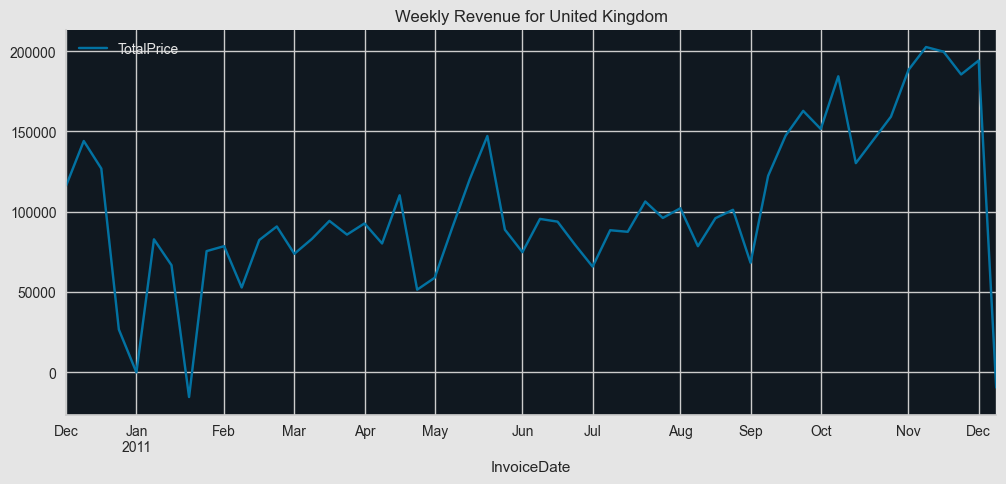

In [9]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

weekly_prices.plot(ax = ax).set_title("Weekly Revenue for United Kingdom")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.show()

Here, we have revenue per week graph. Let's interpret it.

Earlier January, this retailer was closed. Revenue is 0.

We see first peak in the middle of May.

Second peak is in the beginning of October.

Then the revenue top out in the middle of November.

<a id="section-five-one-two"></a>

# 5.1.2) Daily Data

In [10]:
daily_sales = pd.DataFrame(df.groupby("InvoiceDate").sum().resample("D").sum()["TotalPrice"])
daily_sales

,TotalPrice
InvoiceDate,
2010-12-01,34818.17
2010-12-02,40037.08
2010-12-03,16984.44
2010-12-04,0.00
2010-12-05,24610.21
...,...
2011-12-05,46461.82
2011-12-06,36133.38
2011-12-07,30833.81


In [11]:
daily_sales.loc["2010-12-23" : "2011-1-4"]

,TotalPrice
InvoiceDate,
2010-12-23,3759.72
2010-12-24,0.00
2010-12-25,0.00
2010-12-26,0.00
2010-12-27,0.00
2010-12-28,0.00
2010-12-29,0.00
2010-12-30,0.00
2010-12-31,0.00


In [12]:
daily_sales.reset_index(inplace = True)
daily_sales["Closed"] = np.where((daily_sales.TotalPrice == 0), 1, 0)
daily_sales.set_index("InvoiceDate", inplace = True)

In [13]:
daily_sales["weekday"] = daily_sales.index.day_name()
daily_sales

,TotalPrice,Closed,weekday
InvoiceDate,,,
2010-12-01,34818.17,0,Wednesday
2010-12-02,40037.08,0,Thursday
2010-12-03,16984.44,0,Friday
2010-12-04,0.00,1,Saturday
2010-12-05,24610.21,0,Sunday
...,...,...,...
2011-12-05,46461.82,0,Monday
2011-12-06,36133.38,0,Tuesday
2011-12-07,30833.81,0,Wednesday


In [14]:
daily_sales[daily_sales.TotalPrice == 0].weekday.value_counts()

weekday
Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: count, dtype: int64

Okey, we don't have any record at 69 days. 53 of 69 is saturday. This retailer could be closed on saturdays. Let's look at total revenues per weekday.

In [15]:
daily_sales.groupby("weekday").TotalPrice.sum()

weekday
Friday        681662.571
Monday        903307.891
Saturday           0.000
Sunday        667928.401
Thursday     1238888.780
Tuesday       941262.331
Wednesday    1070687.430
Name: TotalPrice, dtype: float64

Yeap, this retailer closed on saturdays.

In [16]:
daily_sales_workdays = daily_sales[daily_sales.TotalPrice > 0].copy()
daily_sales.drop("weekday", axis = 1, inplace = True)
daily_sales_workdays.drop("weekday", axis = 1, inplace = True)

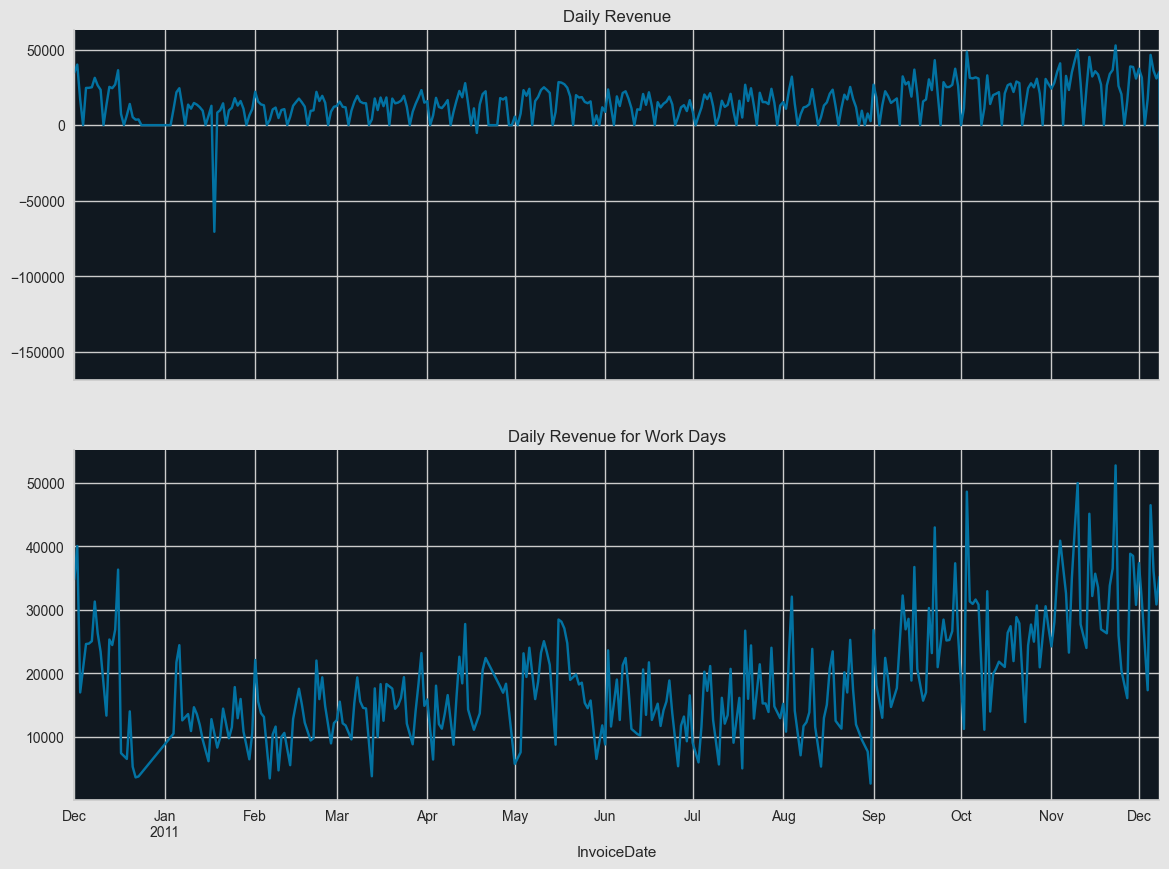

In [17]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

daily_sales.TotalPrice.plot(ax = axes[0]).set_title("Daily Revenue")
daily_sales_workdays.TotalPrice.plot(ax = axes[1]).set_title("Daily Revenue for Work Days")

sns.despine()
plt.show()

As we can see above daily revenue graphs, we have an increasing trend for end of the year.

<a id="section-five-two"></a>

# 5.2) Stationarity

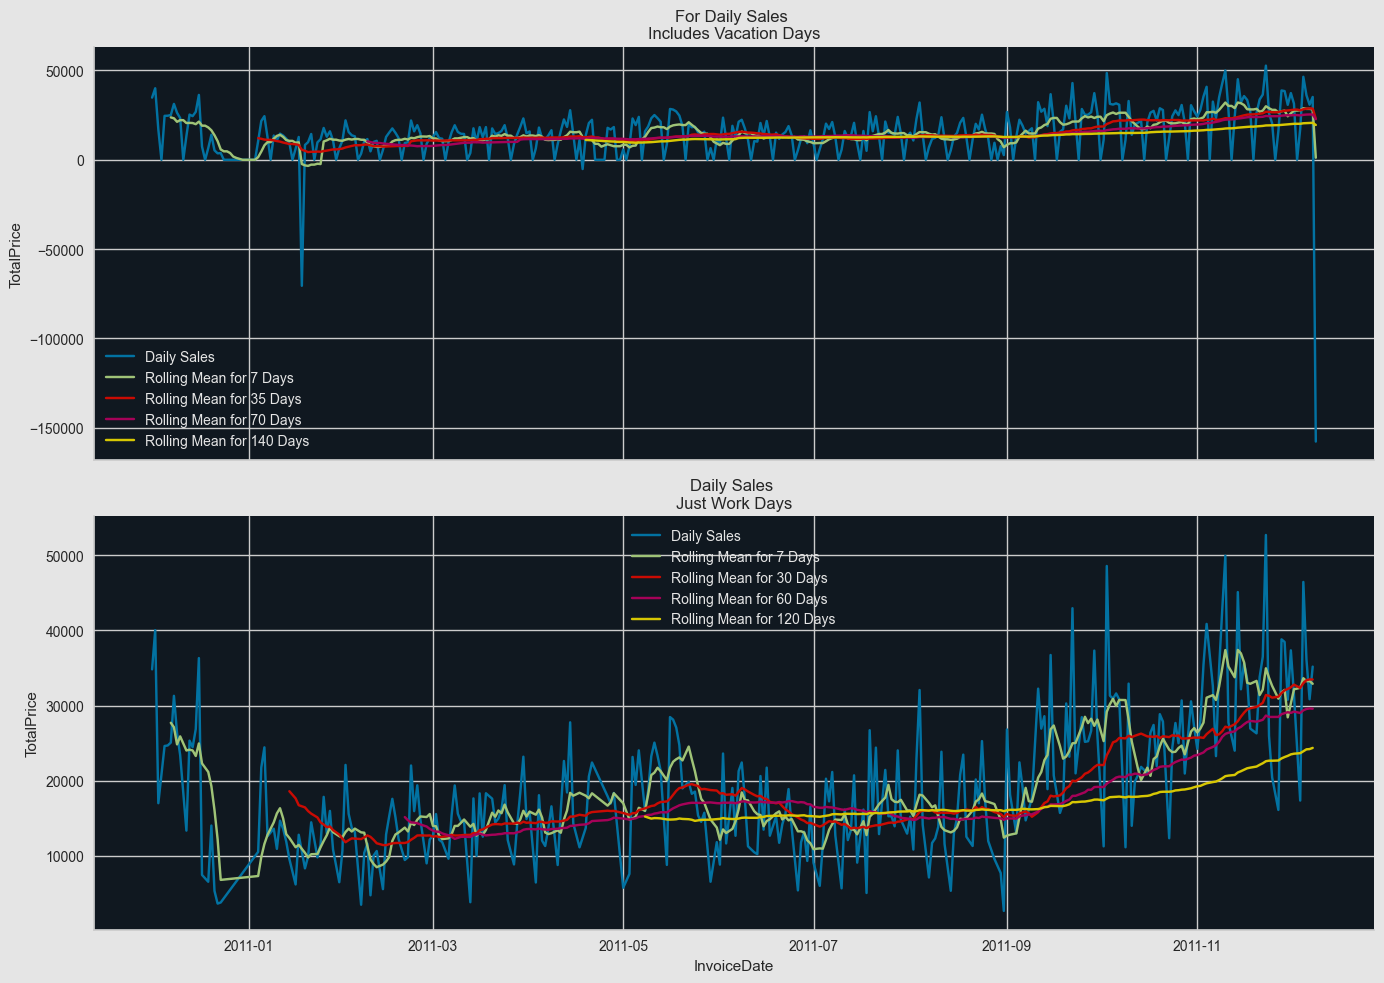

In [18]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
    
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("For Daily Sales \nIncludes Vacation Days")

sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(7).mean(), 
             ax = axes[0], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(35).mean(), 
             ax = axes[0], label = "Rolling Mean for 35 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(70).mean(), 
             ax = axes[0], label = "Rolling Mean for 70 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(140).mean(), 
             ax = axes[0], label = "Rolling Mean for 140 Days")


sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[1], label = "Daily Sales").set_title("Daily Sales \nJust Work Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(6).mean(), 
             ax = axes[1], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(30).mean(),
             ax = axes[1], label = "Rolling Mean for 30 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean for 60 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(120).mean(), 
             ax = axes[1], label = "Rolling Mean for 120 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
    
sns.despine()
plt.tight_layout()
plt.show()

Let's check stationarity. Stationarity simply means that, our series has constant mean, variance on different times.

In above rolling mean plots, we saw that our mean values increase over time.

But, let's check it with Augmented Dickey Fuller test.

<a id="section-five-two-one"></a>

# 5.2.1) Augmented Dickey-Fuller Test

In [19]:
def check_adf(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {adf[0]}")
    pvalue = adf[1]; print(f"p-value: {adf[1]}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [20]:
print("Performing Augmented Dickey-Fuller test for Total Price \n")

check_adf(daily_sales.TotalPrice)

print("\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n")

check_adf(daily_sales_workdays.TotalPrice)

Performing Augmented Dickey-Fuller test for Total Price 

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -2.9867300960152194
p-value: 0.036152363276630586
Number of lags: 15

Critical Values : 

	 1% 	 -3.448748905151901
	 5% 	 -2.8696473721448728
	 10% 	 -2.5710891239349585

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.1144108195554219
p-value: 0.7092909560947762
Number of lags: 14

Critical Values : 

	 1% 	 -3.453342167806272
	 5% 	 -2.871663828287282
	 10% 	 -2.572164381381345

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.


For ADF test, this series is not stationary. To make it stationary, we have two main option.

1- Take difference until it become stationary.

2- Apply transformations: Log, square root, etc.

We can take difference with using .diff() method.

In this problem, our series has seasonal behaivor. Our revenue is increasing from saturday to thursday, then it decrease. For taking difference of seasonal series, we need set period in diff method.

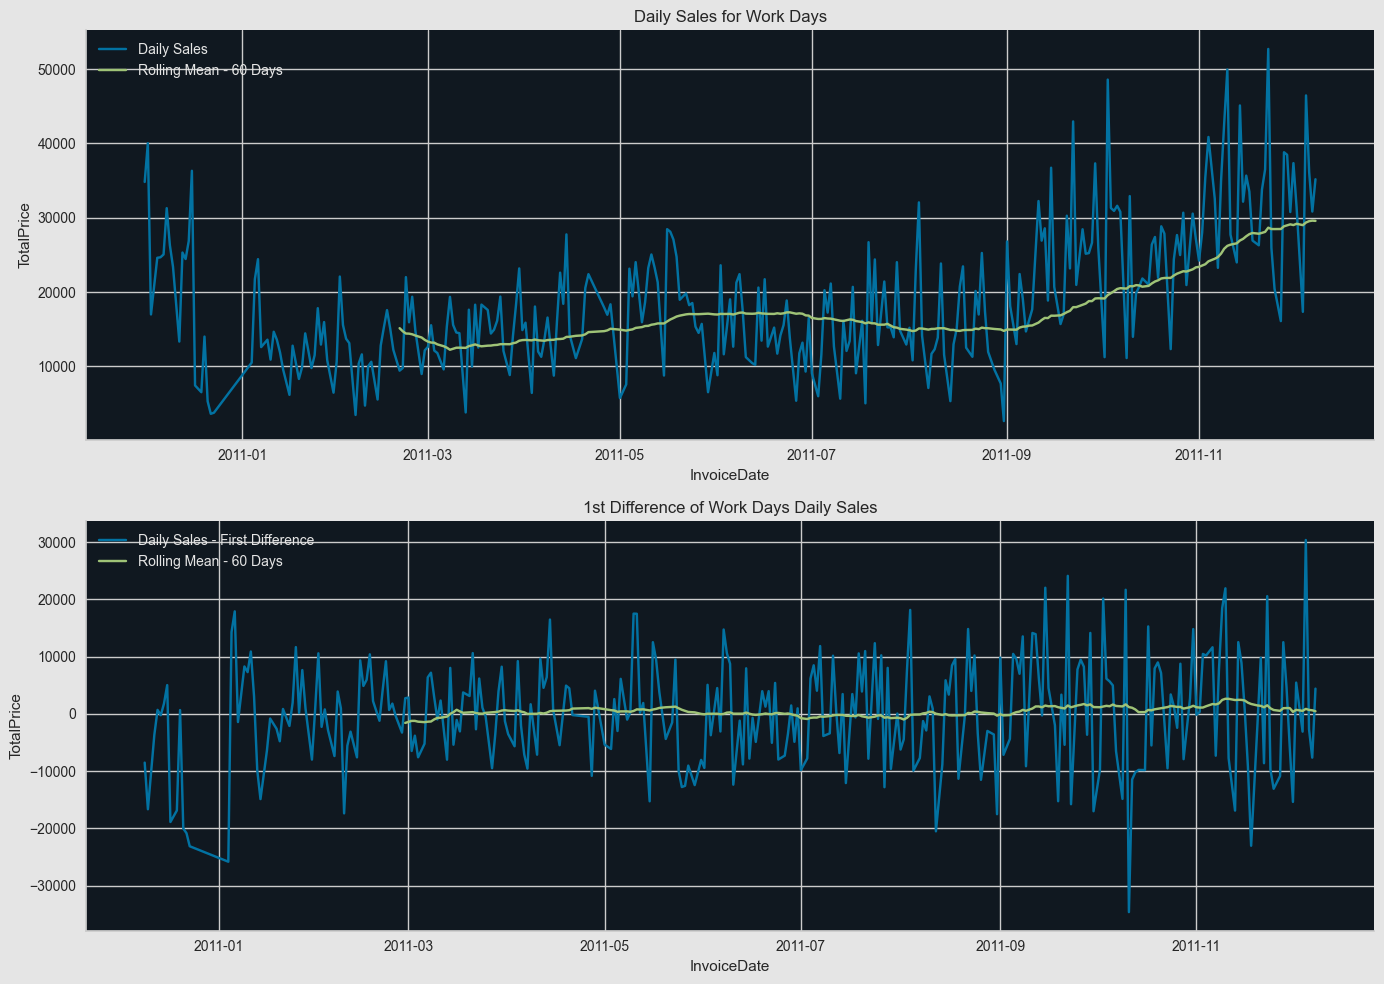

In [21]:
fig, axes = plt.subplots(2, 1, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("Daily Sales for Work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[0], label = "Rolling Mean - 60 Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7), 
             ax = axes[1], label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7).rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean - 60 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

Nice, we have a constant mean over time. Let's look at ADF test results of 1st differenced series.

In [22]:
print("Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)")
check_adf(daily_sales["TotalPrice"].diff(7).dropna())

print("\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales")
check_adf(daily_sales_workdays["TotalPrice"].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -5.222478650076317
p-value: 7.909042963610356e-06
Number of lags: 13

Critical Values : 

	 1% 	 -3.4490114443793214
	 5% 	 -2.8697627072503757
	 10% 	 -2.5711506161673716

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -6.649688453712918
p-value: 5.15833926171607e-09
Number of lags: 11

Critical Values : 

	 1% 	 -3.4535872903895797
	 5% 	 -2.871771355211212
	 10% 	 -2.5722217283277127

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.


<a id="section-five-three"></a>

# 5.3) Seasonality, Decomposition

In [23]:
decompose = seasonal_decompose(daily_sales["TotalPrice"], period = 7)

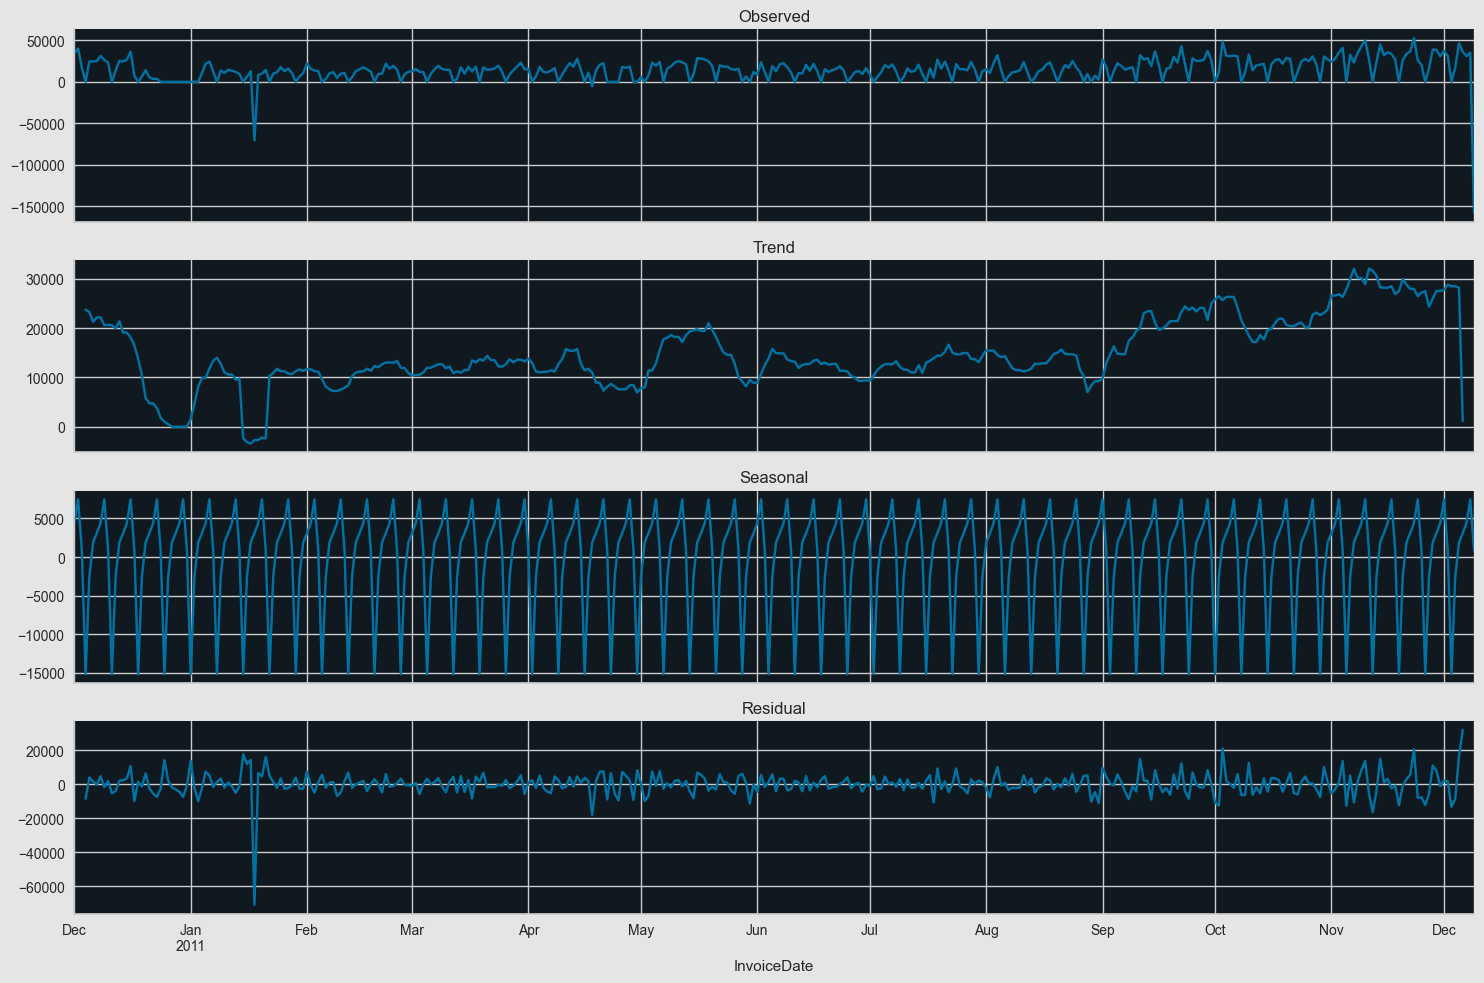

In [24]:
fig, axes = plt.subplots(4, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

decompose.observed.plot(ax = axes[0]).set_title("Observed")
decompose.trend.plot(ax = axes[1]).set_title("Trend")
decompose.seasonal.plot(ax = axes[2]).set_title("Seasonal")
decompose.resid.plot(ax = axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.show()

We can saw trend, seasonal component and residual. We know we have weekly seasonality.

We need normal distributed residual. Let's look at it.

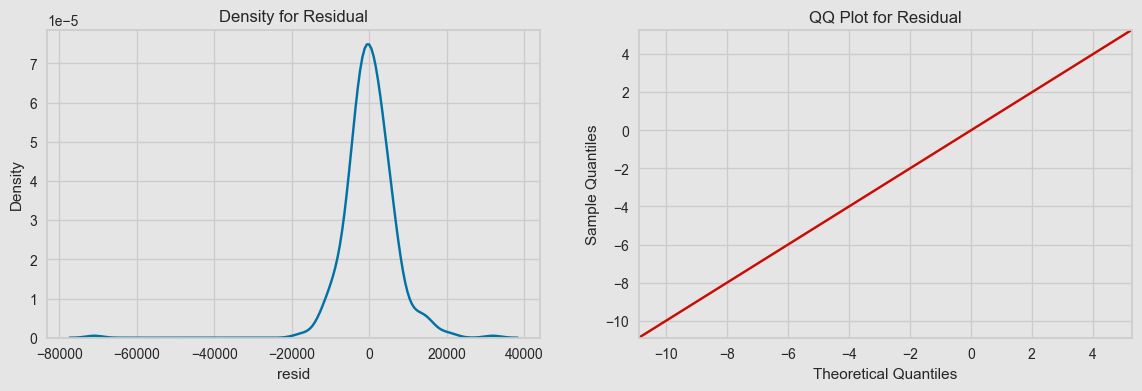

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density for Residual")

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    
    sm.qqplot(decompose.resid.dropna(), ax = axes[1], marker = "x", line = "45", fit = True)
    axes[1].set_title("QQ Plot for Residual")
    
plt.show()

As we can see kde plot and QQ plot, residual has normal distribution.

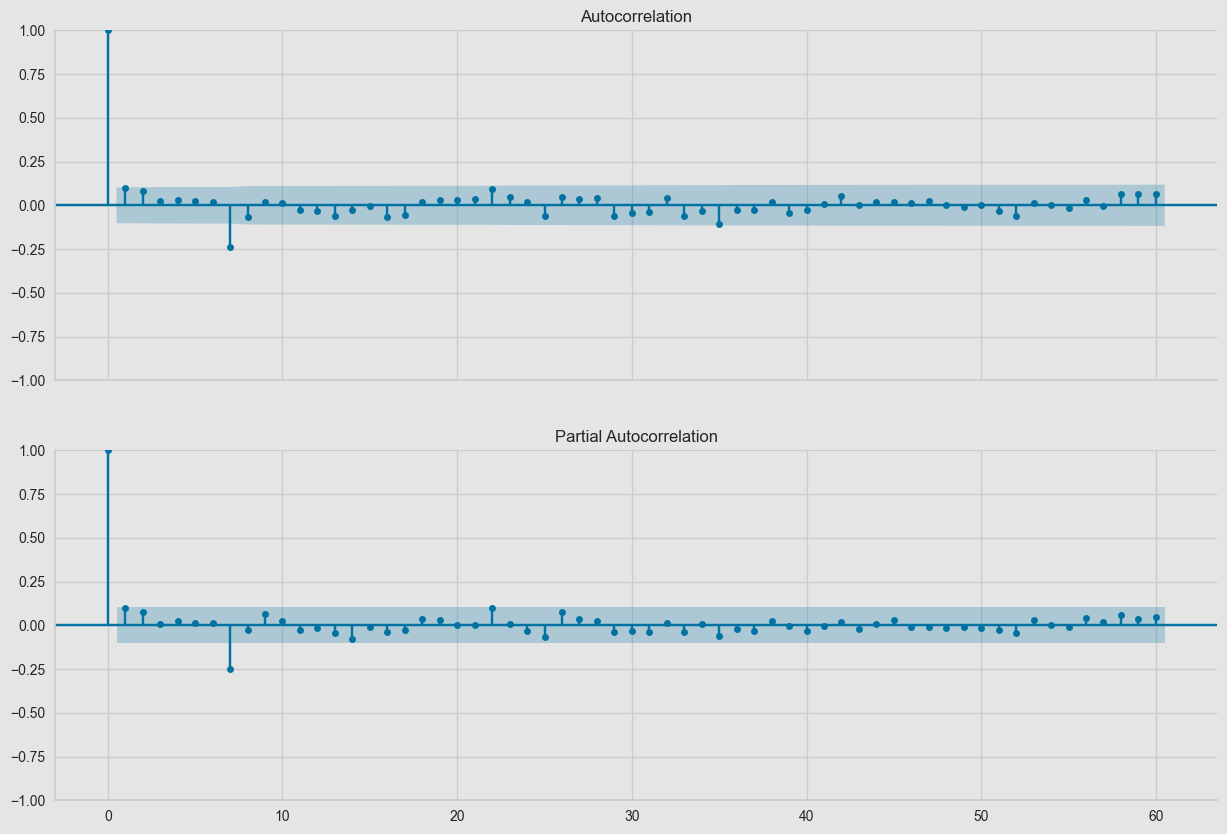

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
plot_acf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[0])
plot_pacf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[1])

sns.despine()
plt.show()

<a id="section-five-four"></a>

# 5.4) Modelling

I will use daily sales data for model training. We have 0 values on saturdays, it is fixed. We can get rid of these records with subsetting the data, just like stock prices. 

For training set, I just get first 85% records of all days, and remaining part is validation set.

First of all, I want to say again, my main goal is getting more detailed project about this dataset. As we talk theoretical part, I think this dataset is not fully convenient for forecasting. We have one year data and after then major peak, we don't have a lot observations to predicting the behaivor of data.

This part would be a simple introduction of Facebook's Prophet, and I probably prepare more detailed notebooks about these concepts.

In [27]:
daily_data = daily_sales[["TotalPrice"]].dropna().reset_index()

daily_data.columns = ["ds", "y"]

train_size = int(0.85 * len(daily_data))

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(train)} \nValidation Days:\t {len(val)}")

Training Days:		317 
Validation Days:	 57


In [28]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

<a id="section-five-four-one"></a>

# 5.4.1) Simple Model

In [29]:
from prophet import Prophet

model = Prophet()

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

09:54:12 - cmdstanpy - INFO - Chain [1] start processing
09:54:12 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.4062286798811704
MSE: 66996375.272242695
Correlation: 0.6375557785544338

For Validation set: 

R2: 0.1036577646971889
MSE: 676984111.4862767
Correlation: 0.3621769647609507


First model is simple prophet model with default parameters. We don't have good results,

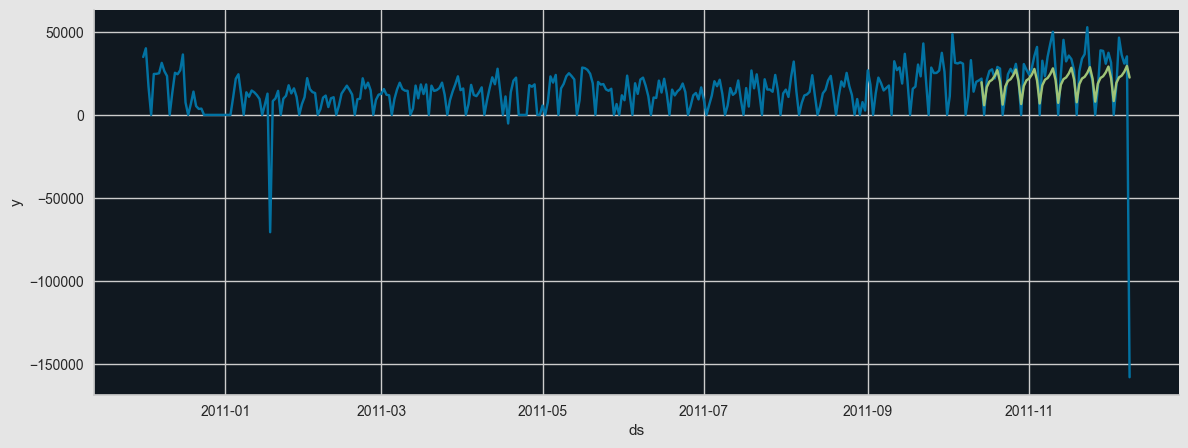

In [31]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax)

sns.despine()
plt.show()

It seems, the model does not capture huge peaks.

Let's add some parameters.

<a id="section-five-four-two"></a>

# 5.4.2) Prophet's parameters

We can add holidays to prophet model with below format.

I just add "Black Friday" as a holiday for three years.

In [32]:
black_friday = pd.DataFrame(
    {
        "holiday": "black friday",
        "ds": pd.to_datetime(["2011-11-24", "2012-11-23", "2013-11-22"]),
        "lower_window": 0,
        "upper_window": 1
    }
)

In saturdays, we don't have any sale record. I will simply add "is_saturday" column as an extra regressor.

In [33]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

Prophet gives lots of options in model building step.

holidays: You can use this for adding special days to model.

seasonality: If the data has seasonality, you can set daily_seasonality, weekly_seasonality, and yearly_seasonality parameters to True.

_prior_scale: This parameter controls the flexibility of components' affects.

In this model, I just set them with simple numbers. You can turn them with [0.01-10] range.

In [34]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

09:54:17 - cmdstanpy - INFO - Chain [1] start processing
09:54:17 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.5404978875938726
MSE: 51846518.88371478
Correlation: 0.7354024902873575

For Validation set: 

R2: 0.04119135078862557
MSE: 724163378.5698326
Correlation: 0.29897695143151104


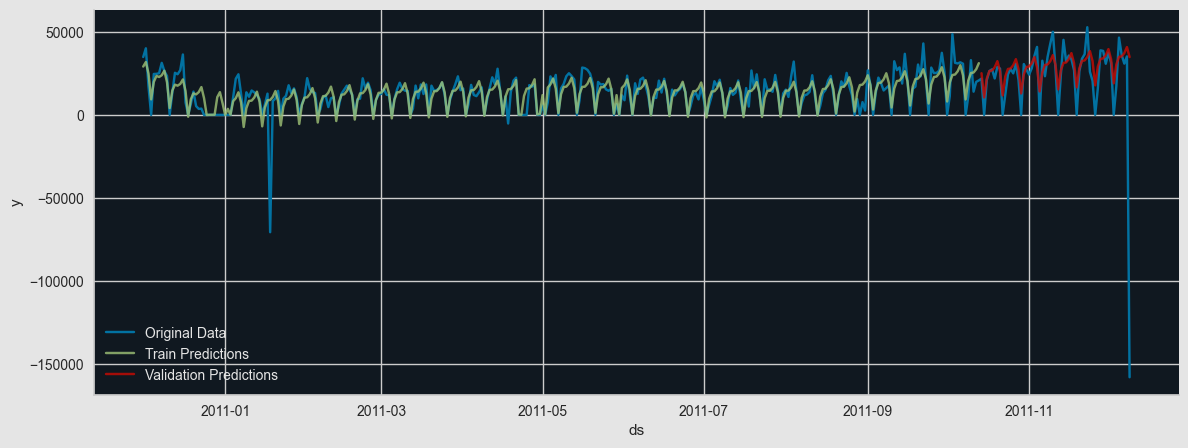

In [36]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

We have a problem, we get negative valued forecasts. Actually, using "floor" and "cap" didn't work for me. http://facebook.github.io/prophet/docs/saturating_forecasts.html#saturating-minimum

To get rid of this, I will manually set them zero.

In [37]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
val_pred["yhat"] = np.where((val_pred.is_saturday == 0), val_pred.yhat, 0)

print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.5578015317948897
MSE: 49894114.984791696
Correlation: 0.7480808675084866

For Validation set: 

R2: 0.08295243614839365
MSE: 692622310.7126049
Correlation: 0.33172154583767677


68% R2 for validation set, good increasing.

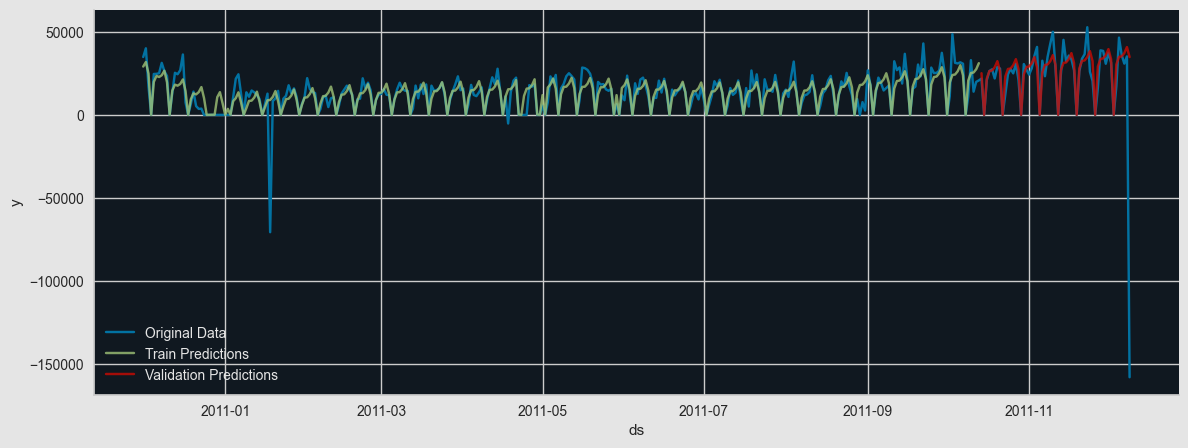

In [38]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

Our model can not capture sudden peaks well. Actually, we have to investigate the reasons underlying this peaks. Is it yearly seasonal, or not? We can not detect it since we have only one year data.

<a id="section-five-four-three"></a>

# 5.4.3) Forecasting Future

Now, I will build a new model for forecasting next year. I just add yearly seasonality to last model that we used.

In [135]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    # yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    # changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

10:09:19 - cmdstanpy - INFO - Chain [1] start processing
10:09:19 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)
future.tail()

,ds,is_saturday
734,2012-12-04,False
735,2012-12-05,False
736,2012-12-06,False
737,2012-12-07,False
738,2012-12-08,True


In [137]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
734,2012-12-04,47803.148210,29788.695441,63245.447325
735,2012-12-05,49682.294241,32275.124883,66672.932097
736,2012-12-06,52910.871371,34300.558581,70505.645491
737,2012-12-07,42930.086049,24850.696232,59549.978660
738,2012-12-08,29955.239520,12191.193646,47027.823675


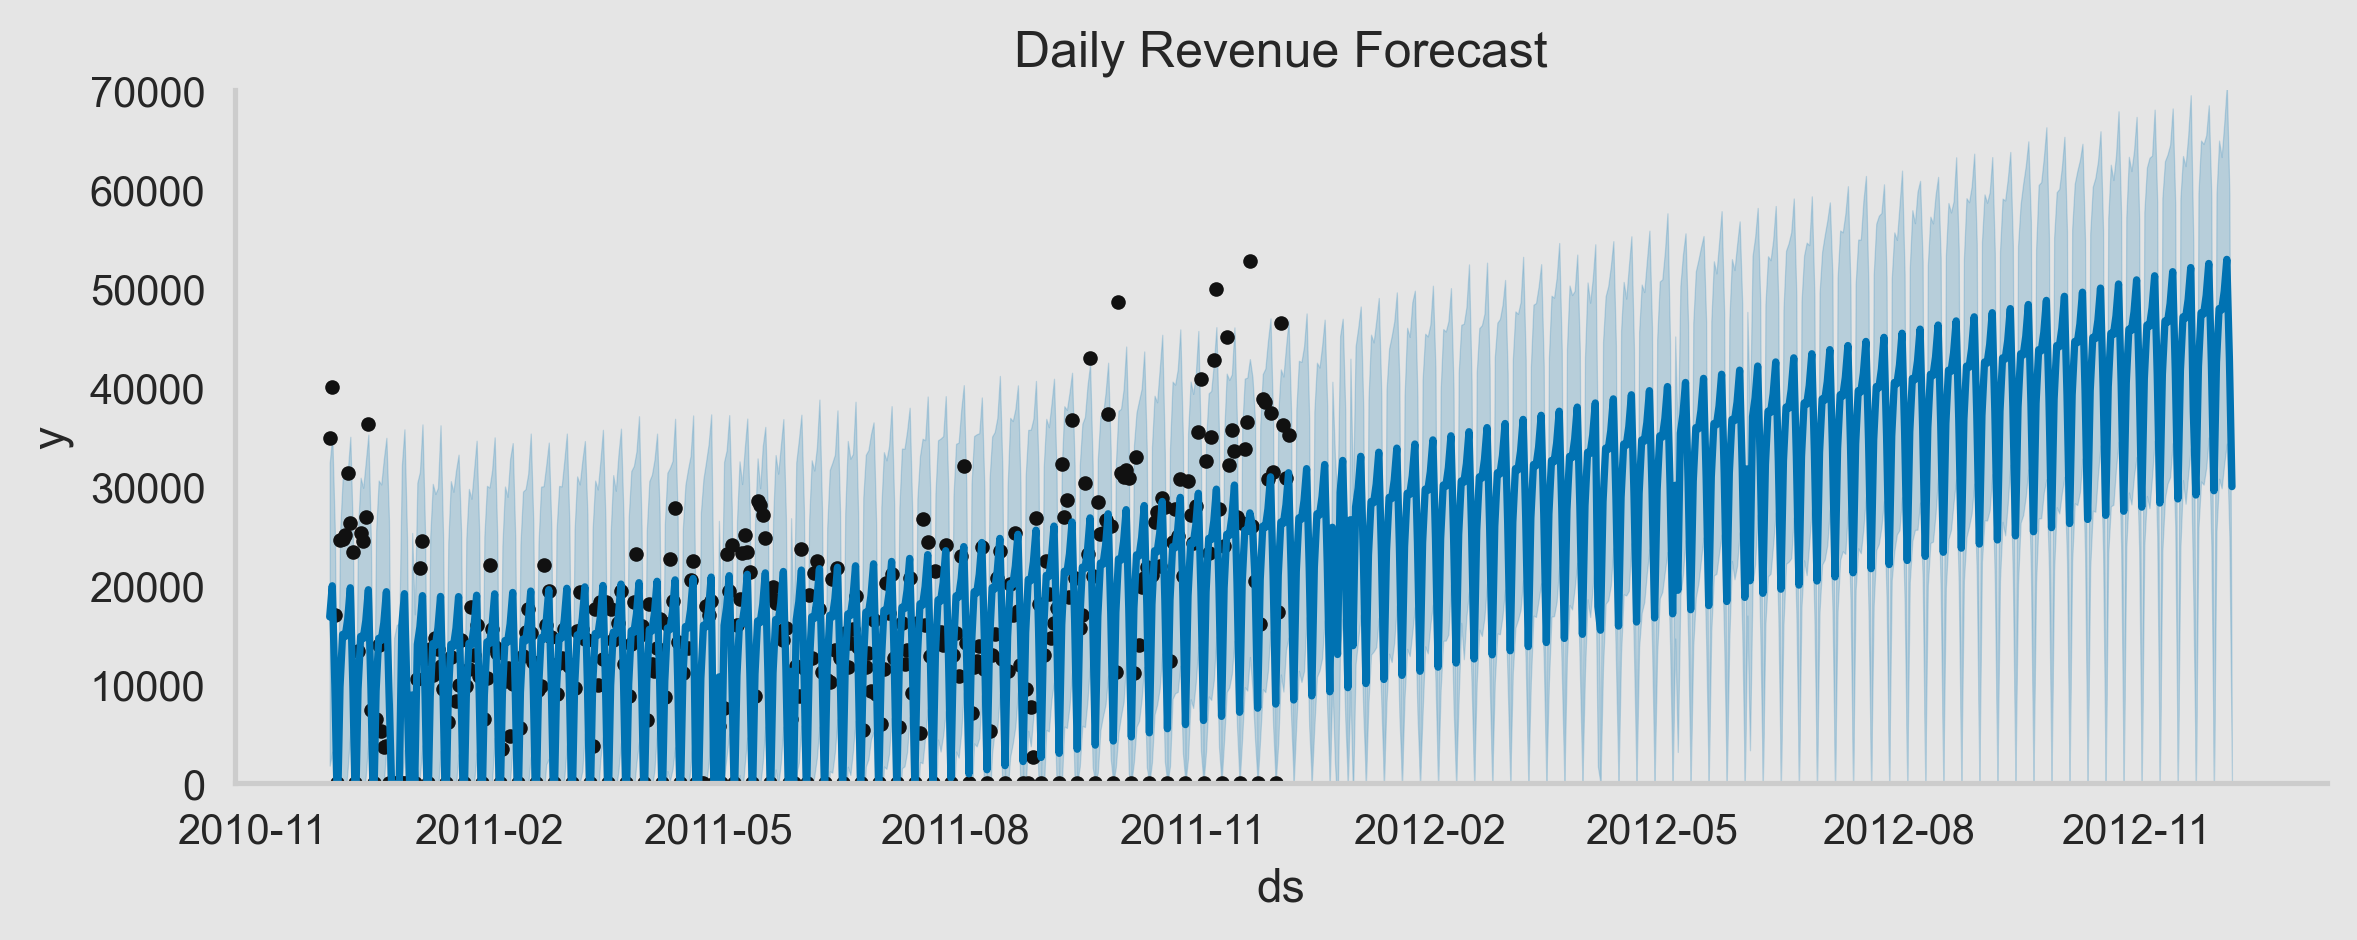

In [138]:
# forecast["yhat"] = np.where((forecast.is_saturday == 0), forecast.yhat, 0)
forecast["yhat_lower"] = np.where((forecast.is_saturday == 0), forecast.yhat_lower, 0)
forecast["yhat_upper"] = np.where((forecast.is_saturday == 0), forecast.yhat_upper, 0)

fig, ax = plt.subplots(figsize = (9, 3), facecolor = "#e5e5e5", dpi = 300)

model.plot(forecast, ax = ax)

ax.set_title("Daily Revenue Forecast")
ax.grid(False)
ax.set_facecolor("#e5e5e5")
ax.set_ylim(0, 70000)

sns.despine()
plt.show()